# MA4702-2022 Laboratorio 1
## Modelamiento y Formulación: Problema de Permutación
## Integrantes

- Manuel Torres 
- Luis Plaza
- Isidora Reyes
- Jonathan Ocampo 

## Observaciones

Si tiene alguna observación a la corrección escríbala acá (claridad del enunciado, díficultades con Julia u otros).

# 1. Preparación

Usaremos los paquetes JuMP, Gurobi y Plots. Descomente los siguientes comandos si no tiene los paquetes y asegúrese de tener la última versión de JuMP corriendo. Vuelvalos a comentar una vez que los ejecute.

In [1]:
#import Pkg
#Pkg.update("JuMP")
#Pkg.add("Plots")
#Pkg.status("JuMP")

In [2]:
using JuMP, Gurobi, Plots
# Abrir un solo ambiente de Gurobi, Jupyter se marea si se crean demasiados modelos durante en una misma celda.
const GUROBI_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-09



(process:5900): GLib-GIO-WARNING **: 22:12:13.770: Unexpectedly, UWP app `3138AweZip.AweZip_1.4.9.0_x86__ffd303wmbhcjt' (AUMId `3138AweZip.AweZip_ffd303wmbhcjt!App') supports 168 extensions but has no verbs

(process:5900): GLib-GIO-WARNING **: 22:12:13.876: Unexpectedly, UWP app `6760NGPDFLab.PDFX_1.3.15.0_x64__sbe4t8mqwq93a' (AUMId `6760NGPDFLab.PDFX_sbe4t8mqwq93a!App') supports 32 extensions but has no verbs


Gurobi.Env(Ptr{Nothing} @0x000000005cdcb7f0, false, 0)

# 2. Funciones Auxiliares

Pueden obtener la instancia de prueba para sus programas gracias a la siguiente función:

In [3]:
# Crea una instancia de prueba para el problema de permutaciones con 15 cajas y objetos.
function crearInstanciaPermutaciones()
    # Cantidad de cajas y objetos
    n = 15
    # Posición en el plano (x,y) de la caja i
    B = [-0.5 0.0; -0.428571428571429 0.0; -0.357142857142857 0.0; -0.285714285714286 0.0; -0.214285714285714 0.0; -0.142857142857143 0.0; -0.0714285714285715 0.0; 0.0 0.0; 0.0714285714285714 0.0; 0.142857142857143 0.0; 0.214285714285714 0.0; 0.285714285714286 0.0; 0.357142857142857 0.0; 0.428571428571429 0.0; 0.5 0.0]
    # Posición en el plano (x,y) del objeto j
    O = [0.864397 -0.614946; 0.094203 -0.254635; -0.851909 -0.26983; 0.873504 -1.671994; -0.438039 -1.876045; -0.429661 0.575006; -1.102729 -0.866133; 0.396247 -2.116523; -0.964925 -0.964466; 0.168449 0.212729; -1.965359 0.477917; -0.744302 0.100658; -0.552307 0.297433; -0.552307 -0.297433; 1.109142 -1.624496]
    return n, B, O
end

n, B, O = crearInstanciaPermutaciones()

(15, [-0.5 0.0; -0.428571428571429 0.0; … ; 0.428571428571429 0.0; 0.5 0.0], [0.864397 -0.614946; 0.094203 -0.254635; … ; -0.552307 -0.297433; 1.109142 -1.624496])

Pueden graficar sus soluciones usando la siguiente función:

In [4]:
# Grafica una solución al problema de permutaciones. M corresponde a la solución en el formato: [caja_i objeto_j; ...]
function graficarPermutaciones(n, B, O, M)
    xB = []
    yB = []
    xO = []
    yO = []
    for i in 1:n
        push!(xB, B[i, 1])
        push!(yB, B[i, 2])
        push!(xO, O[i, 1])
        push!(yO, O[i, 2])
    end
    
    fig = plot()
    scatter!(fig, xB, yB, markershape=:rect, label="Cajas")
    scatter!(fig, xO, yO, label="Objetos")
    
    for i in 1:n
        plot!(fig, [xB[M[i,1]]; xO[M[i,2]]], [yB[M[i,1]]; yO[M[i,2]]], seriescolor=:green, label="")
    end
    return fig
end

graficarPermutaciones (generic function with 1 method)

A continuación un ejemplo de uso para la asignación que a todo objeto $i$ lo pone en la caja $i$.

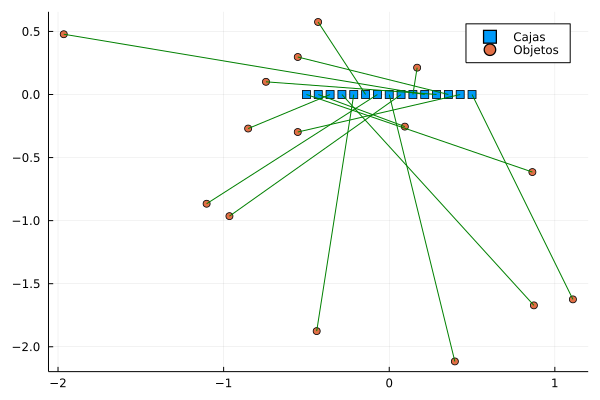

In [5]:
M = [1 1; 2 2; 3 3; 4 4; 5 5; 6 6; 7 7; 8 8; 9 9; 10 10; 11 11; 12 12; 13 13; 14 14; 15 15]
graficarPermutaciones(n, B, O, M)

La siguiente función auxiliar (hecha durante el laboratorio) recibe una matriz de asignaciones y la cantidad de cajas/objetos que hay y entrega una matriz de $n\times2$ con todas las asignaciones realizadas.

In [6]:
function arreglo_de_pares_asignados(W,n)
    #===========================================================
    Funcion auxiliar que entrega una matriz de nx2 donde 
    estan los pares cajas-objetos asignados
    ===========================================================#
    output = zeros(Int, (n, 2))	
    for i in 1:n
        for j in 1:n
            if W[i,j] == 1.
                output[i,1] = j
                output[i,2] = i
            end
        end
    end
    return output
end         

arreglo_de_pares_asignados (generic function with 1 method)

# 3. Respuestas

Escriba sus respuestas aquí, tanto los códigos en Julia como respuestas a preguntas en Markdown.

Puede apoyarse libremente en el siguiente template para generar un modelo del problema.

## Problema 1 - Modelo original

In [7]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Variables
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo, x[1:n,1:n], Bin)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo, sum(x[i,j] for i in 1:n) == 1)
    end
    return modelo
end

modeloPermutaciones (generic function with 1 method)

In [8]:
n, B, O = crearInstanciaPermutaciones()
modelo = modeloPermutaciones(n,B,O);
optimize!(modelo)
va=all_variables(modelo)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1


15×15 Matrix{Float64}:
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0   1.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      1.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0   1.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0   0.0   1.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   0.0  -0.0   0.0   1.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0   0.0   1.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0   0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   1.0  -0.0  -0.0  -0.0  -0.0
  1.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0   1.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0   0.0   1.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -

El valor óptimo de la función es:
objective_value(modelo) = 15.377627809988196
Los pares cajas-objetos asignados son:
pares_asignados = [15 1; 10 2; 3 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 1 11; 2 12; 5 13; 4 14; 14 15]


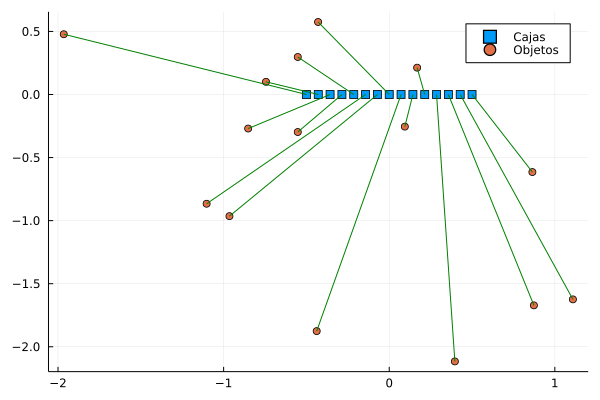

In [9]:
# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

In [10]:
O = [0.864397 -0.614946; 0.094203 -0.254635; -0.851909 -0.26983; 0.873504 -1.671994; -0.438039 -1.876045; -0.429661 0.575006; -1.102729 -0.866133; 0.396247 -2.116523; -0.964925 -0.964466; 0.168449 0.212729; -1.965359 0.477917; -0.744302 0.100658; -0.552307 0.297433; -0.552307 -0.297433; 1.109142 -1.624496]

15×2 Matrix{Float64}:
  0.864397  -0.614946
  0.094203  -0.254635
 -0.851909  -0.26983
  0.873504  -1.67199
 -0.438039  -1.87604
 -0.429661   0.575006
 -1.10273   -0.866133
  0.396247  -2.11652
 -0.964925  -0.964466
  0.168449   0.212729
 -1.96536    0.477917
 -0.744302   0.100658
 -0.552307   0.297433
 -0.552307  -0.297433
  1.10914   -1.6245

## Problema 2 - Modelo relajado
La relajación del modelo considera $x\in[0,1]$ en lugar de $x\in\{0,1\}$, esto significa que el objeto $i$-ésimo se puede asignar en fracciones a la caja $j$-ésima, sin embargo al ser un problema de asignaciones esperamos que su versión relajada tenga la misma solución que el modelo original.

In [11]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo_relajado = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo_relajado)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo_relajado, 0 <= x[1:n,1:n] <= 1)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo_relajado, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for i in 1:n) == 1)
    end
    return modelo_relajado
end

modeloPermutaciones (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo_relajado) = 15.377627809988198
Los pares cajas-objetos asignados son:
pares_asignados = [15 1; 10 2; 3 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 1 11; 2 12; 4 13; 5 14; 14 15]


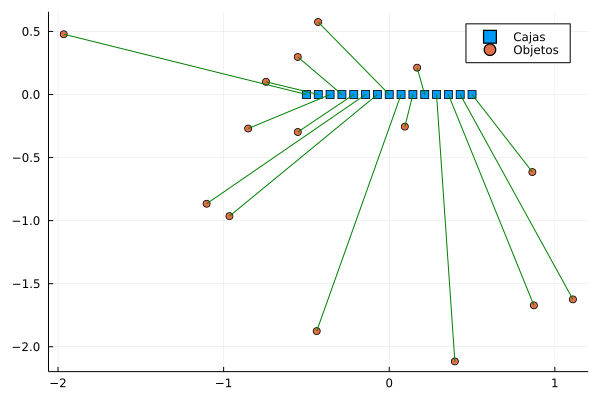

In [12]:
n, B, O = crearInstanciaPermutaciones()
modelo_relajado = modeloPermutaciones(n,B,O);
optimize!(modelo_relajado)
va=all_variables(modelo_relajado)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo_relajado)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

## Problema 3 - Caso particular 1
Añadiremos como restricción que el objeto 1 no puede estar en la caja 1 ni en la última caja.
### Modelo sin relajación

In [13]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo, x[1:n,1:n], Bin)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo, sum(x[i,j] for i in 1:n) == 1)
    end
    @constraint(modelo, x[1,1] == 0)
    @constraint(modelo, x[1,n] == 0)
    return modelo
end

modeloPermutaciones (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo) = 15.390201316164662
Los pares cajas-objetos asignados son:
pares_asignados = [14 1; 10 2; 3 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 1 11; 2 12; 4 13; 5 14; 15 15]


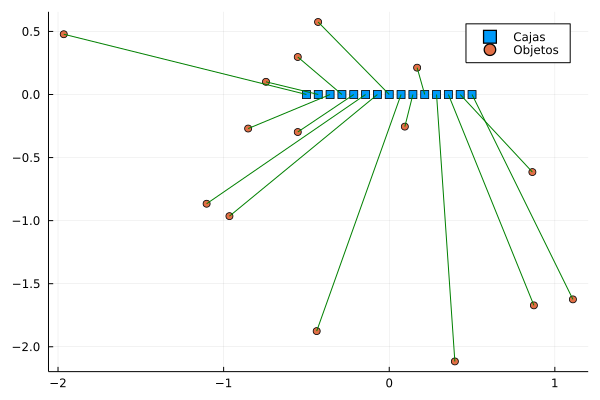

In [14]:
n, B, O = crearInstanciaPermutaciones()
modelo = modeloPermutaciones(n,B,O);
optimize!(modelo)
va=all_variables(modelo)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

### Modelo con relajación

In [15]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo_relajado = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo_relajado)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo_relajado, 0 <= x[1:n,1:n] <= 1)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo_relajado, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for i in 1:n) == 1)
    end
    @constraint(modelo_relajado, x[1,1] == 0)
    @constraint(modelo_relajado, x[1,n] == 0)
    return modelo_relajado
end

modeloPermutaciones (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo_relajado) = 15.390201316164662
Los pares cajas-objetos asignados son:
pares_asignados = [14 1; 10 2; 3 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 1 11; 2 12; 5 13; 4 14; 15 15]


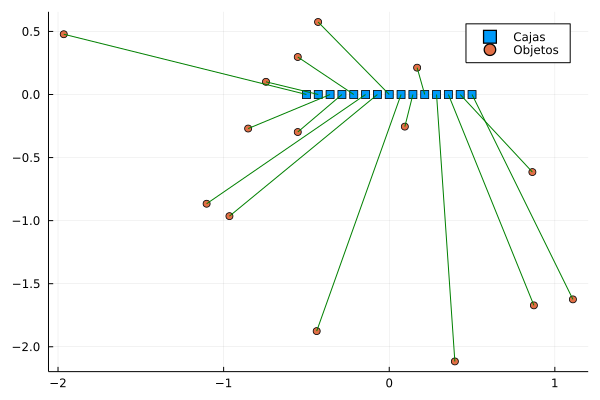

In [16]:
n, B, O = crearInstanciaPermutaciones()
modelo_relajado = modeloPermutaciones(n,B,O);
optimize!(modelo_relajado)
va=all_variables(modelo_relajado)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo_relajado)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

## Problema 4 - Caso particular 2

### Modelo sin relajacion

In [17]:
function modeloPermutacionesp4(n,B,O;verboso=false)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo, x[1:n,1:n], Bin)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo, sum(x[i,j] for i in 1:n) == 1)
    end
    for i in 1:n-1
        @constraint(modelo, x[i+1,2]-x[i,3] == 0)
    end
    @constraint(modelo, x[n,3] == 0)
    return modelo
end

modeloPermutacionesp4 (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo) = 15.393917581623647
Los pares cajas-objetos asignados son:
pares_asignados = [15 1; 10 2; 1 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 3 11; 2 12; 4 13; 5 14; 14 15]


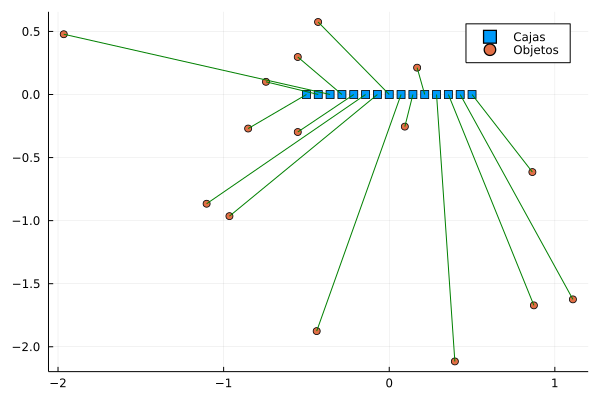

In [18]:
n, B, O = crearInstanciaPermutaciones()
modelo = modeloPermutacionesp4(n,B,O);
optimize!(modelo)
va=all_variables(modelo)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

### Post-laboratorio: No unicidad de la solución en $(\mathcal{P}_{2})$
Notemos que tenemos los pares (objetos,cajas) $(13,4)$ y $(14,5)$, donde podemos observar que los objetos $13$ y $14$ presentan simetría con respecto al eje horizontal en el cual están ubicadas las cajas. Generamos un modelo con la restricción 
\begin{equation}
    x(14,4) = 1,
\end{equation}
con ello esperamos que $x(13,5)=1$ como consecuencia y que el valor objetivo (el valor que adquiere la función objetivo sea el mismo).

In [38]:
function modeloPermutacionesp4(n,B,O;verboso=false)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo, x[1:n,1:n], Bin)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo, sum(x[i,j] for i in 1:n) == 1)
    end
    for i in 1:n-1
        @constraint(modelo, x[i+1,2]-x[i,3] == 0)
    end
    @constraint(modelo, x[n,3] == 0)
    @constraint(modelo, x[14,4] == 1)
    return modelo
end

modeloPermutacionesp4 (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo) = 15.393917581623645
Los pares cajas-objetos asignados son:
pares_asignados = [15 1; 10 2; 1 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 3 11; 2 12; 5 13; 4 14; 14 15]


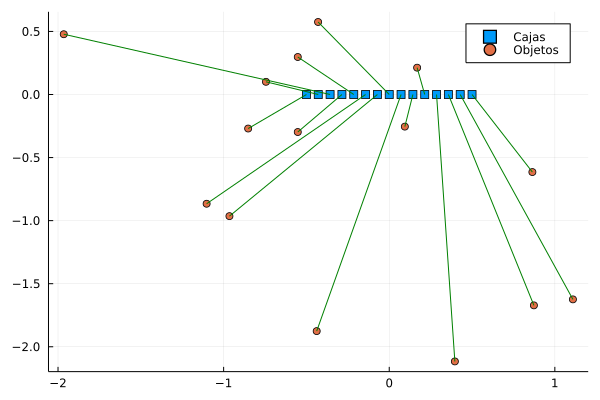

In [39]:
n, B, O = crearInstanciaPermutaciones()
modelo = modeloPermutacionesp4(n,B,O);
optimize!(modelo)
va=all_variables(modelo)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

Notemos que en caso de permutar las asignaciones de los objetos que presentan la simetría ya descrita notamos que el valor que adquiere la función es el mismo, por lo tanto hemos probado que no hay unicidad en la solución.

### Modelo relajado

In [19]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo_relajado = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo_relajado)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)

    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo_relajado,0 <=x[1:n,1:n] <= 1)
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo_relajado, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for i in 1:n) == 1)
    end
    for i in 1:n-1
        @constraint(modelo_relajado, x[i+1,2]-x[i,3] == 0)
    end
    @constraint(modelo_relajado, x[n,3] == 0)
    return modelo_relajado
end

modeloPermutaciones (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo_relajado) = 15.393917581623647
Los pares cajas-objetos asignados son:
pares_asignados = [15 1; 10 2; 1 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 3 11; 2 12; 5 13; 4 14; 14 15]


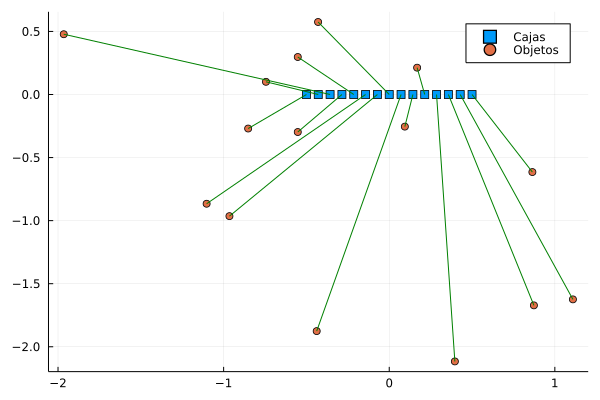

In [20]:
n, B, O = crearInstanciaPermutaciones()
modelo_relajado = modeloPermutaciones(n,B,O);
optimize!(modelo_relajado)
va=all_variables(modelo_relajado)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo_relajado)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

## Problema 5 - Caso particular 3
Al modelo original añadimos la restricción
$$
    (\forall i =1,\dots,n),\qquad x_{i,4} + \sum_{|k| \leq 3} x_{i+k,5} \leq 1
$$
### Modelo sin relajación

In [31]:
# Template para inicializar modelo y condiciones del solver
function modeloPermutaciones(n,B,O;verboso=false)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo, x[1:n,1:n], Bin)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo, sum(x[i,j] for i in 1:n) == 1)
    end
    # Restriccion problema 5
    for i in 1:n-3
        @constraint(modelo, x[1,4] + sum(x[i+k,5] for k in 0:3) <= 1)
    end
    for i in 1:n-2
        @constraint(modelo, x[1,4] + sum(x[i+k,5] for k in 0:2) <= 1)
    end
    for i in 1:n-1
        @constraint(modelo, x[1,4] + sum(x[i+k,5] for k in 0:1) <= 1)
    end
    return modelo
end

modeloPermutaciones (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo) = 15.377627809988196
Los pares cajas-objetos asignados son:
pares_asignados = [15 1; 10 2; 3 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 1 11; 2 12; 4 13; 5 14; 14 15]


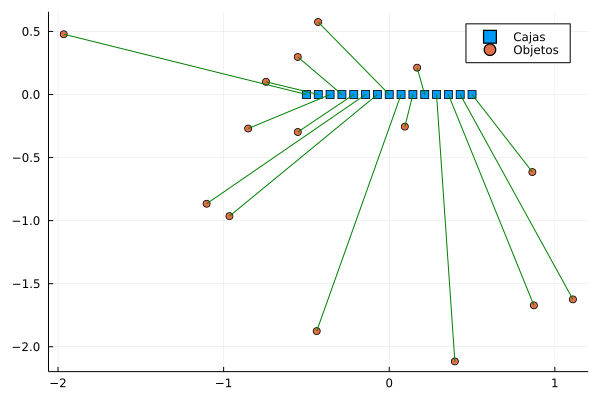

In [32]:
n, B, O = crearInstanciaPermutaciones()
modelo = modeloPermutaciones(n,B,O);
optimize!(modelo)
va=all_variables(modelo)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

### Post-laboratorio: No unicidad de la solución en $(\mathcal{P}_{3})$
En la solución tenemos las asignaciones de objetos $(4,13)$ y $(5,14)$. Notamos que los objetos $13$ y $14$ poseen una posición simétrica con respecto a la recta horizontal sobre la cual se ubican las cajas. Generamos un modelo con la restricción 
\begin{equation}
    x(14,4) = 1,
\end{equation}
con ello esperamos que $x(5,13)=1$ como consecuencia y que el valor objetivo (el valor que adquiere la función objetivo sea el mismo).

### Modelo relajado

In [23]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo_relajado = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo_relajado)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo_relajado, 0 <= x[1:n,1:n] <= 1)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo_relajado, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for i in 1:n) == 1)
    end
    # Restriccion problema 5
    for i in 1:n-3
        @constraint(modelo_relajado, x[1,4] + sum(x[i+k,5] for k in 0:3) <= 1)
    end
    for i in 1:n-2
        @constraint(modelo_relajado, x[1,4] + sum(x[i+k,5] for k in 0:2) <= 1)
    end
    for i in 1:n-1
        @constraint(modelo_relajado, x[1,4] + sum(x[i+k,5] for k in 0:1) <= 1)
    end
    @constraint(modelo_relajado, x[1,1] == 0)
    @constraint(modelo_relajado, x[1,n] == 0)
    return modelo_relajado
end

modeloPermutaciones (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo_relajado) = 15.390201316164662
Los pares cajas-objetos asignados son:
pares_asignados = [14 1; 10 2; 3 3; 13 4; 9 5; 8 6; 6 7; 12 8; 7 9; 11 10; 1 11; 2 12; 5 13; 4 14; 15 15]


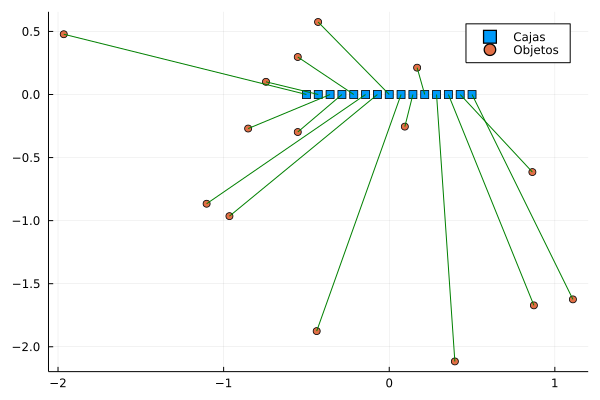

In [24]:
n, B, O = crearInstanciaPermutaciones()
modelo_relajado = modeloPermutaciones(n,B,O);
optimize!(modelo_relajado)
va=all_variables(modelo_relajado)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo_relajado)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

In [25]:
## Problema 4 - Caso particular 3

## Problema 6 - Caso particular 4
Consideraremos como restricción lo siguiente: Debe haber como máximo 2 cajas entre las cajas que contienen los objetos 6 y 7.
### Modelo sin relajar

In [26]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo, x[1:n,1:n], Bin)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo, sum(x[i,j] for i in 1:n) == 1)
    end
    # Restriccion problema 6
    for i in 1:n-3
        @constraint(modelo, x[i,6] - sum(x[i+k,7] for k in 0:3) <= 0)
    end
    for i in 1:n-2
        @constraint(modelo, x[i,6] - sum(x[i+k,7] for k in 0:2) <= 0)
    end
    for i in 1:n-1
        @constraint(modelo, x[i,6] - sum(x[i+k,7] for k in 0:1) <= 0)
    end
    return modelo
end

modeloPermutaciones (generic function with 1 method)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo_relajado) = 15.404670684201202
Los pares cajas-objetos asignados son:
pares_asignados = [15 1; 10 2; 3 3; 13 4; 9 5; 8 6; 4 7; 12 8; 5 9; 11 10; 1 11; 2 12; 6 13; 7 14; 14 15]


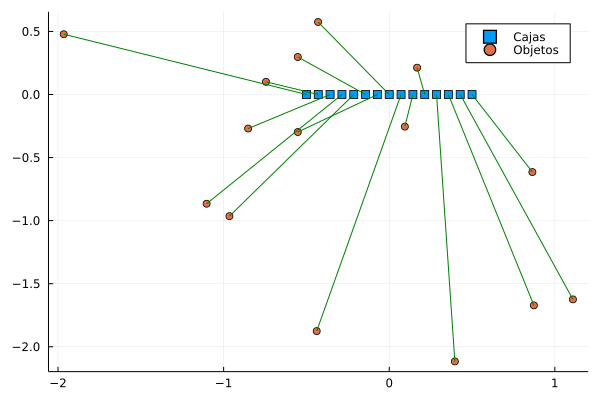

In [27]:
n, B, O = crearInstanciaPermutaciones()
modelo_relajado = modeloPermutaciones(n,B,O);
optimize!(modelo_relajado)
va=all_variables(modelo_relajado)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo_relajado)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
graficarPermutaciones(n, B, O, pares_asignados)

### Modelo relajado

In [28]:
function modeloPermutaciones(n,B,O;verboso=false)
    modelo_relajado = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"Presolve"=>0, "Cuts"=> 0, "Heuristics"=> 0, "Threads"=>1))
        if !verboso
            set_silent(modelo_relajado)
        end
    #===========================================================
    Formato de objetos de un problema de optimizacion
    ===========================================================#
    #     @variable(modelo, variables_con_sus_dominios, )
    #     @objective(modelo, Min, expresion_de_la_funcion_objetivo)
    #     @constraints(modelo, begin
    #         primeraRestriccion ...
    #     end)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #= 
    La variable es una matriz X = (x_{ij})_{i,n\leq n} de 
    variables booleanas donde x_{i,j} = 1 si el objeto i se 
    encuentra asignado a la caja j, x_{i,j} = 0 en caso contrario
    =#
    @variable(modelo_relajado, 0 <= x[1:n,1:n] <= 1)
    
    #===========================================================
    Funcion objetivo
    ===========================================================#
    #=
    La funcion objetivo es tal que minimiza la suma de las dist.
    entre los pares de objetos y cajas asignadas.
    =#
    @objective(modelo_relajado, Min, sum(x[i,j]*sqrt((O[i,1]-B[j,1])^2 + 
                (O[i,2]-B[j,2])^2) for i in 1:n, j in 1:n))
    
    #===========================================================
    Restricciones
    ===========================================================#
    # Todo objeto esta asignado en solamente una caja
    for i in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for j in 1:n) == 1)
    end
    # A toda cada se le asigna solamente un objeto
    for j in 1:n
        @constraint(modelo_relajado, sum(x[i,j] for i in 1:n) == 1)
    end
    # Restriccion problema 6
    for i in 1:n-3
        @constraint(modelo_relajado, x[i,6] - sum(x[i+k,7] for k in 0:3) <= 0)
    end
    for i in 1:n-2
        @constraint(modelo_relajado, x[i,6] - sum(x[i+k,7] for k in 0:2) <= 0)
    end
    for i in 1:n-1
        @constraint(modelo_relajado, x[i,6] - sum(x[i+k,7] for k in 0:1) <= 0)
    end
    @constraint(modelo_relajado, x[1,1] == 0)
    @constraint(modelo_relajado, x[1,n] == 0)
    return modelo_relajado
end

modeloPermutaciones (generic function with 1 method)

In [29]:
n, B, O = crearInstanciaPermutaciones()
modelo_relajado = modeloPermutaciones(n,B,O);
optimize!(modelo_relajado)
va=all_variables(modelo_relajado)
val=value.(va)
val=reshape(val,(n,n)) #cambio a matriz nxn

# Plot del test de asignacion
pares_asignados = arreglo_de_pares_asignados(val,n)
println("El valor óptimo de la función es:")
@show objective_value(modelo_relajado)
println("Los pares cajas-objetos asignados son:")
@show pares_asignados
println("Notemos que el óptimo se da cuando se entrega una asignación fraccionaria")
print(val)
# graficarPermutaciones(n, B, O, pares_asignados)

Set parameter Presolve to value 0
Set parameter Cuts to value 0
Set parameter Heuristics to value 0
Set parameter Threads to value 1
El valor óptimo de la función es:
objective_value(modelo_relajado) = 15.393412210696724
Los pares cajas-objetos asignados son:
pares_asignados = [14 1; 10 2; 3 3; 13 4; 9 5; 8 6; 0 0; 12 8; 0 0; 11 10; 1 11; 2 12; 4 13; 5 14; 15 15]
Notemos que el óptimo se da cuando se entrega una asignación fraccionaria
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.

## Respuestas sobre los resultados del laboratorio
### Comparación modelos con y sin relajación para cada problema planteado

Como podemos ver en los resultados, para los problemas 1 y 2 se obtienen iguales soluciones en la asignación y para la función objetivo mediante el modelo sin relajar y el modelo relajado respectivo. Además pudimos constatar en problemas derivados del original añadiendo restricciones (problemas 3, 4, 5) que en cada caso las soluciones han sido equivalentes en asignación y a valores óptimos iguales para la función objetivo.

### Observación problema 6
Para el problema 6 la solución óptima del problema relajado se da cuando se entrega una asignación fraccionaria, lo que imposibilita mostrar el gráfico de la asignación (se muestra la matriz de asignaciones en los resultados).


## Post-laboratorio
### Problema 1
Notemos que para los problemas de optimización $\mathcal{P}_{2}$ y $\mathcal{P}_{3}$ la solución no es única. Esto se presenta en las sub-secciones etiquetadas como *post-laboratorio* en donde se mustra una permutación sobre la asignación caja-objeto óptima que obtiene un valor óptimo.

El algoritmo al tomar el objeto $13$ asignado a la caja $4$ identifica que el objeto $14$ se encuentra a la misa distancia de esta, luego el algoritmo sigue con el objeto $14$ el cual está asignado a la caja $5$ e identifica que el objeto 13 se encuentra a la misma distancia de esta, luego como el objeto $13$ ya se encontraba visitado se realiza la permutación encontrando una nueva solución de igual valor ya que las distancias totales no se alteraron.

 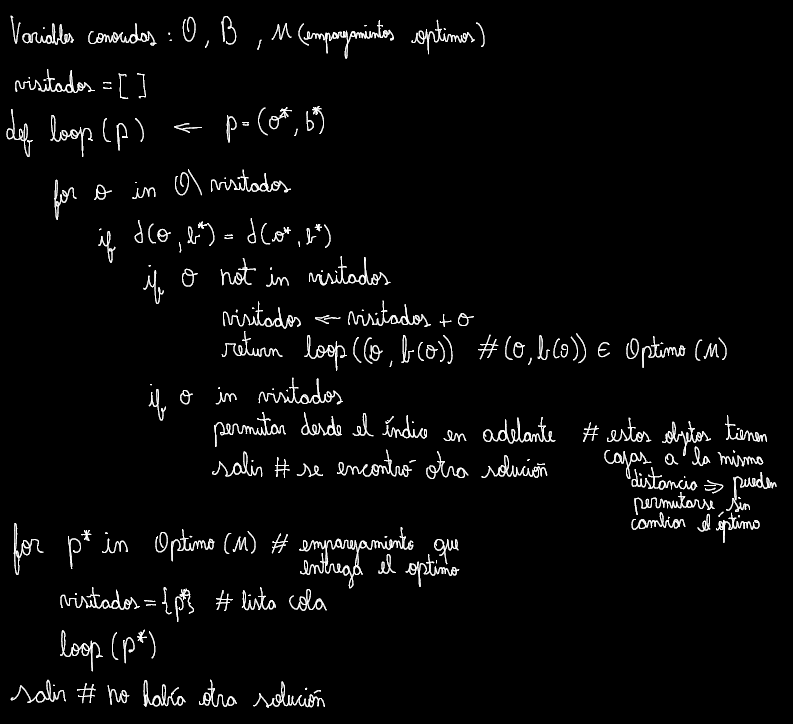! 
 
 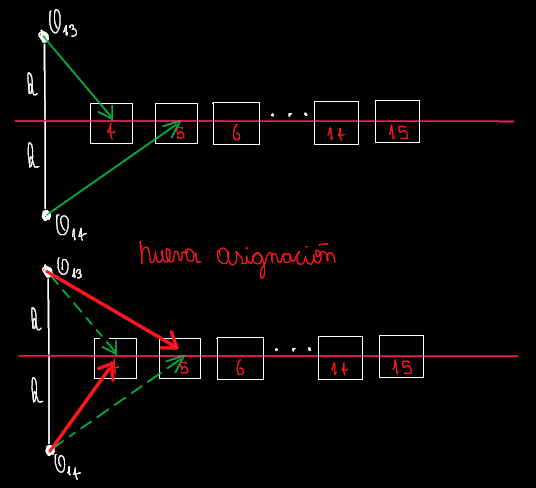

### Problema 2
#### Discusión
Una matriz totalmente unimodular son las matrices tales que cada submatriz cuadrada tiene determinante 0, 1 o -1.
De acuerdo a la ley de kramer, si la matriz de restricciones está dada por una matriz totalmente unimodular, entonces las soluciones básicas del problema serán enteras, luego analizamos la matriz de restricciones del problema $\mathcal{P}_0$, este problema es la base de los demás problemas los cuales añaden una restricción(de ceros y unos) en cada caso.
#### Matriz de restricción del problema original
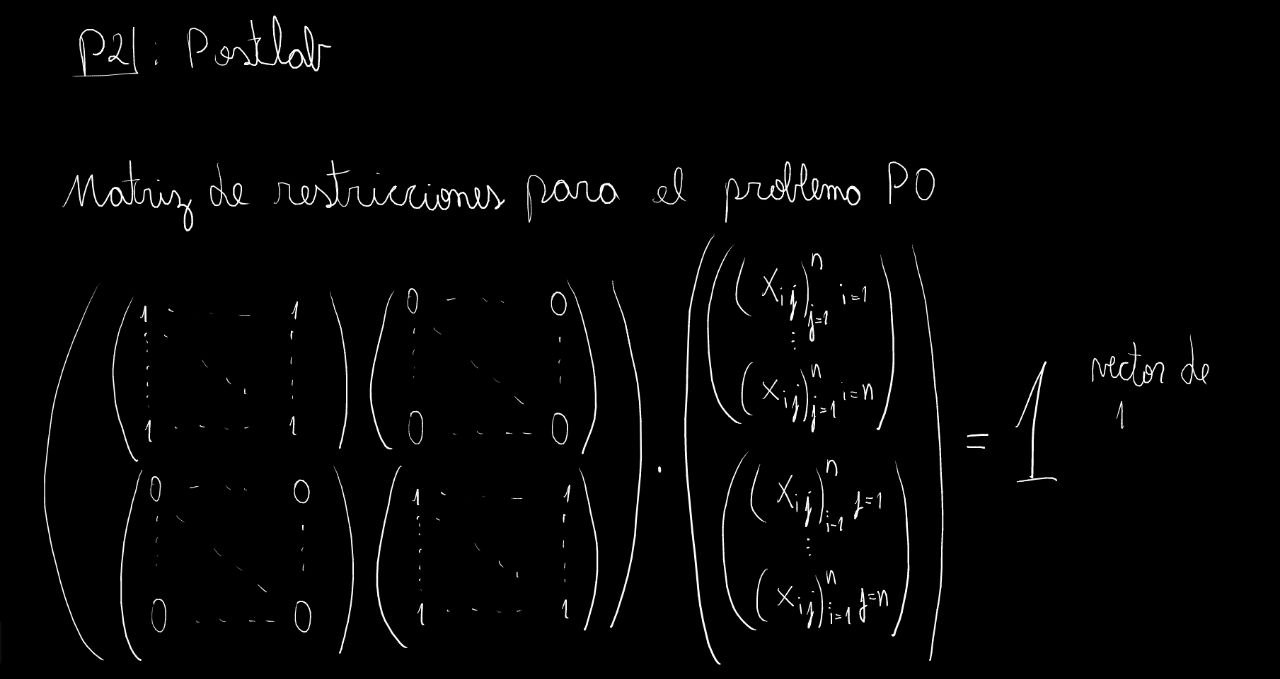

Notemos que en esta matriz todos los subdeterminantes posibles son $-1$, $0$ ó $1$. Las restricciones añadidas en los problemas posteriores durante el laboratorio preservaban esta propiedad, sin embargo la restricción añadida en el prolema 6 (modelo $\mathcal{P}_{4}$) rompe esto, y entrega una matriz que obiene algún subdeterminante fuera de $\{0,1,-1\}$, por lo que no entrega soluciones enteras.